In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed

import tensorflow as tf
from exnn import xNN

## Simulation Settings

In [2]:
def mse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.mean((pred - label)**2)

def simu_loader(generator, datanum, testnum, noise_sigma):
    def wrapper(rand_seed=0):
        return generator(datanum, testnum=testnum, noise_sigma=noise_sigma, rand_seed=rand_seed)
    return wrapper

def data_generator1(datanum, testnum=10000, noise_sigma=1, rand_seed=0):
    
    corr = 0.5
    np.random.seed(rand_seed)
    proj_matrix = np.zeros((10, 4))
    proj_matrix[:7, 0] = np.array([1,0,0,0,0,0,0])
    proj_matrix[:7, 1] = np.array([0,1,0,0,0,0,0])
    proj_matrix[:7, 2] = np.array([0,0,0.5,0.5,0,0,0])
    proj_matrix[:7, 3] = np.array([0,0,0,0,0.2,0.3,0.5])
    u = np.random.uniform(-1, 1, [datanum + testnum, 1])
    t = np.sqrt(corr / (1 - corr))
    x = np.zeros((datanum + testnum, 10))
    for i in range(10):
        x[:, i:i + 1] = (np.random.uniform(-1, 1, [datanum + testnum, 1]) + t * u) / (1 + t)

    y = np.reshape(2 * np.dot(x, proj_matrix[:, 0]) + 0.2 * np.exp(-4 * np.dot(x, proj_matrix[:, 1])) + \
                   3 * (np.dot(x, proj_matrix[:, 2]))**2 + 2.5 * np.sin(np.pi * np.dot(x, proj_matrix[:, 3])), [-1, 1]) + \
              noise_sigma * np.random.normal(0, 1, [datanum + testnum, 1])
    
    task_type = "Regression"
    meta_info = {"X1":{"type":"continuous"},
             "X2":{"type":"continuous"},
             "X3":{"type":"continuous"},
             "X4":{"type":"continuous"},
             "X5":{"type":"continuous"},
             "X6":{"type":"continuous"},
             "X7":{"type":"continuous"},
             "X8":{"type":"continuous"},
             "X9":{"type":"continuous"},
             "X10":{"type":"continuous"},
             "Y":{"type":"target"}}
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == "target":
            sy = MinMaxScaler((-1, 1))
            y = sy.fit_transform(y)
            meta_info[key]["scaler"] = sy
        elif item['type'] == "categorical":
            enc = OrdinalEncoder()
            enc.fit(x[:,[i]])
            ordinal_feature = enc.transform(x[:,[i]])
            x[:,[i]] = ordinal_feature
            meta_info[key]["values"] = enc.categories_[0].tolist()
        else:
            sx = MinMaxScaler((-1, 1))
            x[:,[i]] = sx.fit_transform(x[:,[i]])
            meta_info[key]["scaler"] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=testnum, random_state=rand_seed)
    return train_x, test_x, train_y, test_y, task_type, meta_info

train_x, test_x, train_y, test_y, task_type, meta_info = data_generator1(datanum=10000, testnum=10000, noise_sigma=1, rand_seed=0)

## Grid Search in Parallel

In [3]:
def xnn_repeat(folder, name, data_generator,
                  subnet_num=10,
                  subnet_arch=[10, 6],
                  task="Regression",
                  activation_func=tf.tanh,
                  lr_bp=0.001,
                  l1_proj=0.001,
                  l1_subnet=0.001,
                  batch_size=1000,
                  training_epochs=5000,
                  tuning_epochs=500,
                  beta_threshold=0.05,
                  verbose=False,
                  val_ratio=0.2,
                  early_stop_thres=1000,
                  rand_seed=0):

    train_x, test_x, train_y, test_y, task_type, meta_info = data_generator(rand_seed)

    input_num = train_x.shape[1]
    model = xNN(meta_info=meta_info,
                   subnet_num=10,
                   subnet_arch=subnet_arch,
                   task_type=task_type,
                   activation_func=tf.tanh,
                   batch_size=min(batch_size, int(train_x.shape[0] * 0.2)),
                   training_epochs=training_epochs,
                   lr_bp=lr_bp,
                   beta_threshold=beta_threshold,
                   tuning_epochs=tuning_epochs,
                   l1_proj=l1_proj,
                   l1_subnet=l1_subnet,
                   verbose=verbose,
                   val_ratio=val_ratio,
                   early_stop_thres=early_stop_thres)
    model.fit(train_x, train_y)
    model.visualize(folder=folder,
                    name=name,
                    save_eps=False)

    tr_pred = model.predict(model.tr_x)
    val_pred = model.predict(model.val_x)
    pred_test = model.predict(test_x)

    if task_type == "Regression":
        stat = np.hstack([np.round(mse(model.tr_y, tr_pred, meta_info["Y"]["scaler"]), 5),\
                              np.round(mse(model.val_y, val_pred, meta_info["Y"]["scaler"]), 5),\
                              np.round(mse(test_y, pred_test, meta_info["Y"]["scaler"]), 5)])
    elif task_type == "Classification":
        stat = np.hstack([np.round(auc(model.tr_y, tr_pred), 5),\
                          np.round(auc(model.val_y, val_pred), 5),\
                          np.round(auc(test_y, pred_test), 5)])

    res_stat = pd.DataFrame(np.vstack([stat[0], stat[1], stat[2]]).T, columns=['train_metric', "val_metric", "test_metric"])
    res_stat["Subnet_Number"] = min(input_num, 10)
    res_stat["lr_BP"] = lr_bp
    res_stat["L1_Penalty_Proj"] = l1_proj
    res_stat["L1_Penalty_Subnet"] = l1_subnet
    res_stat["Training_Epochs"] = training_epochs
    return res_stat

In [4]:
cv_results = Parallel(n_jobs=25)(delayed(xnn_repeat)(folder="./results/S1_xnn/",
                      name=str(i + 1).zfill(2) + "_" + str(j + 1).zfill(2),
                      data_generator=simu_loader(data_generator1, 10000, 10000, 1),
                      task=task_type,
                      subnet_arch=[10, 6],
                      beta_threshold=0.05,
                      l1_proj=10**(-2 - i*0.5),
                      l1_subnet=10**(-2 - j*0.5),
                      training_epochs=10000,
                      lr_bp=0.001,
                      batch_size=1000,
                      early_stop_thres=500,
                      tuning_epochs=100,
                      rand_seed=0) for i in range(5) for j in range(5) for k in [1])
sosxnn_stat_all = pd.concat(cv_results)
sosxnn_stat_all.sort_values("val_metric")

,train_metric,val_metric,test_metric,Subnet_Number,lr_BP,L1_Penalty_Proj,L1_Penalty_Subnet,Training_Epochs
0,0.99941,1.02802,0.99131,10,0.001,0.000100,0.000100,10000
0,1.00005,1.02963,0.99138,10,0.001,0.000100,0.000316,10000
0,1.00077,1.03103,0.99088,10,0.001,0.000100,0.001000,10000
0,1.00694,1.03507,0.99288,10,0.001,0.000316,0.000100,10000
0,1.00873,1.03597,0.99592,10,0.001,0.000316,0.000316,10000
0,1.01114,1.03796,0.99696,10,0.001,0.000316,0.001000,10000
0,1.08260,1.11844,1.06516,10,0.001,0.003162,0.001000,10000
0,1.08184,1.12036,1.06764,10,0.001,0.003162,0.000100,10000
0,1.08229,1.12094,1.06543,10,0.001,0.001000,0.001000,10000
0,1.08266,1.12331,1.06826,10,0.001,0.003162,0.000316,10000


In [5]:
best_l1_prob = sosxnn_stat_all.sort_values("val_metric").loc[:,"L1_Penalty_Proj"].iloc[0]
best_l1_subnet = sosxnn_stat_all.sort_values("val_metric").loc[:,"L1_Penalty_Subnet"].iloc[0]

Initial training.


W1209 18:42:19.808708 140370578847552 deprecation.py:323] From /home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/tensorflow_core/python/autograph/impl/api.py:330: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.


Training epoch: 1, train loss: 0.05167, val loss: 0.05170
Training epoch: 2, train loss: 0.04446, val loss: 0.04462
Training epoch: 3, train loss: 0.04094, val loss: 0.04136
Training epoch: 4, train loss: 0.03951, val loss: 0.03995
Training epoch: 5, train loss: 0.03852, val loss: 0.03902
Training epoch: 6, train loss: 0.03759, val loss: 0.03819
Training epoch: 7, train loss: 0.03690, val loss: 0.03754
Training epoch: 8, train loss: 0.03621, val loss: 0.03688
Training epoch: 9, train loss: 0.03550, val loss: 0.03618
Training epoch: 10, train loss: 0.03480, val loss: 0.03549
Training epoch: 11, train loss: 0.03410, val loss: 0.03481
Training epoch: 12, train loss: 0.03345, val loss: 0.03415
Training epoch: 13, train loss: 0.03285, val loss: 0.03356
Training epoch: 14, train loss: 0.03235, val loss: 0.03308
Training epoch: 15, train loss: 0.03191, val loss: 0.03266
Training epoch: 16, train loss: 0.03154, val loss: 0.03228
Training epoch: 17, train loss: 0.03118, val loss: 0.03195
Traini

Training epoch: 140, train loss: 0.01634, val loss: 0.01689
Training epoch: 141, train loss: 0.01633, val loss: 0.01687
Training epoch: 142, train loss: 0.01629, val loss: 0.01685
Training epoch: 143, train loss: 0.01627, val loss: 0.01682
Training epoch: 144, train loss: 0.01632, val loss: 0.01686
Training epoch: 145, train loss: 0.01626, val loss: 0.01679
Training epoch: 146, train loss: 0.01626, val loss: 0.01683
Training epoch: 147, train loss: 0.01625, val loss: 0.01681
Training epoch: 148, train loss: 0.01624, val loss: 0.01678
Training epoch: 149, train loss: 0.01616, val loss: 0.01670
Training epoch: 150, train loss: 0.01613, val loss: 0.01665
Training epoch: 151, train loss: 0.01612, val loss: 0.01663
Training epoch: 152, train loss: 0.01613, val loss: 0.01663
Training epoch: 153, train loss: 0.01612, val loss: 0.01663
Training epoch: 154, train loss: 0.01606, val loss: 0.01658
Training epoch: 155, train loss: 0.01606, val loss: 0.01658
Training epoch: 156, train loss: 0.01611

Training epoch: 277, train loss: 0.01538, val loss: 0.01584
Training epoch: 278, train loss: 0.01539, val loss: 0.01588
Training epoch: 279, train loss: 0.01545, val loss: 0.01596
Training epoch: 280, train loss: 0.01539, val loss: 0.01587
Training epoch: 281, train loss: 0.01538, val loss: 0.01585
Training epoch: 282, train loss: 0.01538, val loss: 0.01583
Training epoch: 283, train loss: 0.01537, val loss: 0.01584
Training epoch: 284, train loss: 0.01539, val loss: 0.01586
Training epoch: 285, train loss: 0.01541, val loss: 0.01587
Training epoch: 286, train loss: 0.01540, val loss: 0.01585
Training epoch: 287, train loss: 0.01543, val loss: 0.01588
Training epoch: 288, train loss: 0.01563, val loss: 0.01602
Training epoch: 289, train loss: 0.01536, val loss: 0.01584
Training epoch: 290, train loss: 0.01539, val loss: 0.01587
Training epoch: 291, train loss: 0.01544, val loss: 0.01593
Training epoch: 292, train loss: 0.01556, val loss: 0.01608
Training epoch: 293, train loss: 0.01537

Training epoch: 415, train loss: 0.01535, val loss: 0.01577
Training epoch: 416, train loss: 0.01534, val loss: 0.01582
Training epoch: 417, train loss: 0.01537, val loss: 0.01586
Training epoch: 418, train loss: 0.01528, val loss: 0.01574
Training epoch: 419, train loss: 0.01550, val loss: 0.01600
Training epoch: 420, train loss: 0.01549, val loss: 0.01599
Training epoch: 421, train loss: 0.01537, val loss: 0.01585
Training epoch: 422, train loss: 0.01534, val loss: 0.01583
Training epoch: 423, train loss: 0.01528, val loss: 0.01574
Training epoch: 424, train loss: 0.01540, val loss: 0.01588
Training epoch: 425, train loss: 0.01552, val loss: 0.01602
Training epoch: 426, train loss: 0.01529, val loss: 0.01575
Training epoch: 427, train loss: 0.01527, val loss: 0.01571
Training epoch: 428, train loss: 0.01531, val loss: 0.01579
Training epoch: 429, train loss: 0.01530, val loss: 0.01573
Training epoch: 430, train loss: 0.01526, val loss: 0.01572
Training epoch: 431, train loss: 0.01533

Training epoch: 553, train loss: 0.01527, val loss: 0.01570
Training epoch: 554, train loss: 0.01522, val loss: 0.01568
Training epoch: 555, train loss: 0.01521, val loss: 0.01567
Training epoch: 556, train loss: 0.01525, val loss: 0.01571
Training epoch: 557, train loss: 0.01522, val loss: 0.01567
Training epoch: 558, train loss: 0.01523, val loss: 0.01568
Training epoch: 559, train loss: 0.01521, val loss: 0.01566
Training epoch: 560, train loss: 0.01522, val loss: 0.01567
Training epoch: 561, train loss: 0.01523, val loss: 0.01568
Training epoch: 562, train loss: 0.01520, val loss: 0.01565
Training epoch: 563, train loss: 0.01523, val loss: 0.01570
Training epoch: 564, train loss: 0.01521, val loss: 0.01566
Training epoch: 565, train loss: 0.01521, val loss: 0.01565
Training epoch: 566, train loss: 0.01521, val loss: 0.01565
Training epoch: 567, train loss: 0.01522, val loss: 0.01568
Training epoch: 568, train loss: 0.01523, val loss: 0.01566
Training epoch: 569, train loss: 0.01524

Training epoch: 693, train loss: 0.01523, val loss: 0.01570
Training epoch: 694, train loss: 0.01523, val loss: 0.01569
Training epoch: 695, train loss: 0.01519, val loss: 0.01564
Training epoch: 696, train loss: 0.01518, val loss: 0.01563
Training epoch: 697, train loss: 0.01519, val loss: 0.01563
Training epoch: 698, train loss: 0.01520, val loss: 0.01566
Training epoch: 699, train loss: 0.01519, val loss: 0.01565
Training epoch: 700, train loss: 0.01520, val loss: 0.01564
Training epoch: 701, train loss: 0.01520, val loss: 0.01565
Training epoch: 702, train loss: 0.01517, val loss: 0.01563
Training epoch: 703, train loss: 0.01520, val loss: 0.01564
Training epoch: 704, train loss: 0.01518, val loss: 0.01564
Training epoch: 705, train loss: 0.01528, val loss: 0.01575
Training epoch: 706, train loss: 0.01525, val loss: 0.01572
Training epoch: 707, train loss: 0.01518, val loss: 0.01561
Training epoch: 708, train loss: 0.01519, val loss: 0.01565
Training epoch: 709, train loss: 0.01520

Training epoch: 833, train loss: 0.01519, val loss: 0.01565
Training epoch: 834, train loss: 0.01516, val loss: 0.01561
Training epoch: 835, train loss: 0.01516, val loss: 0.01562
Training epoch: 836, train loss: 0.01518, val loss: 0.01564
Training epoch: 837, train loss: 0.01520, val loss: 0.01566
Training epoch: 838, train loss: 0.01517, val loss: 0.01563
Training epoch: 839, train loss: 0.01517, val loss: 0.01561
Training epoch: 840, train loss: 0.01521, val loss: 0.01566
Training epoch: 841, train loss: 0.01522, val loss: 0.01565
Training epoch: 842, train loss: 0.01525, val loss: 0.01572
Training epoch: 843, train loss: 0.01525, val loss: 0.01567
Training epoch: 844, train loss: 0.01518, val loss: 0.01564
Training epoch: 845, train loss: 0.01527, val loss: 0.01569
Training epoch: 846, train loss: 0.01521, val loss: 0.01565
Training epoch: 847, train loss: 0.01523, val loss: 0.01568
Training epoch: 848, train loss: 0.01520, val loss: 0.01565
Training epoch: 849, train loss: 0.01519

Training epoch: 973, train loss: 0.01520, val loss: 0.01567
Training epoch: 974, train loss: 0.01516, val loss: 0.01560
Training epoch: 975, train loss: 0.01522, val loss: 0.01566
Training epoch: 976, train loss: 0.01527, val loss: 0.01567
Training epoch: 977, train loss: 0.01514, val loss: 0.01559
Training epoch: 978, train loss: 0.01532, val loss: 0.01573
Training epoch: 979, train loss: 0.01514, val loss: 0.01559
Training epoch: 980, train loss: 0.01516, val loss: 0.01559
Training epoch: 981, train loss: 0.01521, val loss: 0.01568
Training epoch: 982, train loss: 0.01515, val loss: 0.01560
Training epoch: 983, train loss: 0.01514, val loss: 0.01557
Training epoch: 984, train loss: 0.01515, val loss: 0.01559
Training epoch: 985, train loss: 0.01529, val loss: 0.01572
Training epoch: 986, train loss: 0.01538, val loss: 0.01580
Training epoch: 987, train loss: 0.01519, val loss: 0.01562
Training epoch: 988, train loss: 0.01515, val loss: 0.01558
Training epoch: 989, train loss: 0.01517

Training epoch: 1108, train loss: 0.01516, val loss: 0.01560
Training epoch: 1109, train loss: 0.01520, val loss: 0.01562
Training epoch: 1110, train loss: 0.01516, val loss: 0.01560
Training epoch: 1111, train loss: 0.01519, val loss: 0.01560
Training epoch: 1112, train loss: 0.01518, val loss: 0.01560
Training epoch: 1113, train loss: 0.01522, val loss: 0.01568
Training epoch: 1114, train loss: 0.01514, val loss: 0.01559
Training epoch: 1115, train loss: 0.01528, val loss: 0.01574
Training epoch: 1116, train loss: 0.01514, val loss: 0.01559
Training epoch: 1117, train loss: 0.01515, val loss: 0.01558
Training epoch: 1118, train loss: 0.01516, val loss: 0.01560
Training epoch: 1119, train loss: 0.01516, val loss: 0.01560
Training epoch: 1120, train loss: 0.01519, val loss: 0.01560
Training epoch: 1121, train loss: 0.01517, val loss: 0.01562
Training epoch: 1122, train loss: 0.01528, val loss: 0.01574
Training epoch: 1123, train loss: 0.01519, val loss: 0.01564
Training epoch: 1124, tr

Training epoch: 1247, train loss: 0.01514, val loss: 0.01556
Training epoch: 1248, train loss: 0.01519, val loss: 0.01561
Training epoch: 1249, train loss: 0.01545, val loss: 0.01588
Training epoch: 1250, train loss: 0.01527, val loss: 0.01567
Training epoch: 1251, train loss: 0.01525, val loss: 0.01569
Training epoch: 1252, train loss: 0.01519, val loss: 0.01564
Training epoch: 1253, train loss: 0.01517, val loss: 0.01563
Training epoch: 1254, train loss: 0.01513, val loss: 0.01556
Training epoch: 1255, train loss: 0.01513, val loss: 0.01556
Training epoch: 1256, train loss: 0.01514, val loss: 0.01559
Training epoch: 1257, train loss: 0.01518, val loss: 0.01559
Training epoch: 1258, train loss: 0.01513, val loss: 0.01555
Training epoch: 1259, train loss: 0.01515, val loss: 0.01560
Training epoch: 1260, train loss: 0.01513, val loss: 0.01557
Training epoch: 1261, train loss: 0.01513, val loss: 0.01557
Training epoch: 1262, train loss: 0.01520, val loss: 0.01562
Training epoch: 1263, tr

Training epoch: 1382, train loss: 0.01512, val loss: 0.01555
Training epoch: 1383, train loss: 0.01523, val loss: 0.01570
Training epoch: 1384, train loss: 0.01521, val loss: 0.01565
Training epoch: 1385, train loss: 0.01515, val loss: 0.01556
Training epoch: 1386, train loss: 0.01512, val loss: 0.01557
Training epoch: 1387, train loss: 0.01512, val loss: 0.01555
Training epoch: 1388, train loss: 0.01511, val loss: 0.01555
Training epoch: 1389, train loss: 0.01511, val loss: 0.01554
Training epoch: 1390, train loss: 0.01512, val loss: 0.01555
Training epoch: 1391, train loss: 0.01515, val loss: 0.01559
Training epoch: 1392, train loss: 0.01514, val loss: 0.01559
Training epoch: 1393, train loss: 0.01513, val loss: 0.01556
Training epoch: 1394, train loss: 0.01521, val loss: 0.01563
Training epoch: 1395, train loss: 0.01516, val loss: 0.01557
Training epoch: 1396, train loss: 0.01513, val loss: 0.01558
Training epoch: 1397, train loss: 0.01511, val loss: 0.01554
Training epoch: 1398, tr

Training epoch: 1521, train loss: 0.01517, val loss: 0.01561
Training epoch: 1522, train loss: 0.01512, val loss: 0.01554
Training epoch: 1523, train loss: 0.01512, val loss: 0.01555
Training epoch: 1524, train loss: 0.01510, val loss: 0.01555
Training epoch: 1525, train loss: 0.01515, val loss: 0.01557
Training epoch: 1526, train loss: 0.01514, val loss: 0.01558
Training epoch: 1527, train loss: 0.01510, val loss: 0.01554
Training epoch: 1528, train loss: 0.01512, val loss: 0.01557
Training epoch: 1529, train loss: 0.01513, val loss: 0.01558
Training epoch: 1530, train loss: 0.01513, val loss: 0.01556
Training epoch: 1531, train loss: 0.01510, val loss: 0.01554
Training epoch: 1532, train loss: 0.01512, val loss: 0.01556
Training epoch: 1533, train loss: 0.01510, val loss: 0.01554
Training epoch: 1534, train loss: 0.01512, val loss: 0.01556
Training epoch: 1535, train loss: 0.01515, val loss: 0.01561
Training epoch: 1536, train loss: 0.01510, val loss: 0.01553
Training epoch: 1537, tr

Training epoch: 1656, train loss: 0.01516, val loss: 0.01560
Training epoch: 1657, train loss: 0.01509, val loss: 0.01554
Training epoch: 1658, train loss: 0.01511, val loss: 0.01556
Training epoch: 1659, train loss: 0.01511, val loss: 0.01553
Training epoch: 1660, train loss: 0.01510, val loss: 0.01555
Training epoch: 1661, train loss: 0.01510, val loss: 0.01553
Training epoch: 1662, train loss: 0.01512, val loss: 0.01554
Training epoch: 1663, train loss: 0.01515, val loss: 0.01561
Training epoch: 1664, train loss: 0.01523, val loss: 0.01568
Training epoch: 1665, train loss: 0.01516, val loss: 0.01561
Training epoch: 1666, train loss: 0.01525, val loss: 0.01565
Training epoch: 1667, train loss: 0.01511, val loss: 0.01553
Training epoch: 1668, train loss: 0.01509, val loss: 0.01554
Training epoch: 1669, train loss: 0.01509, val loss: 0.01553
Training epoch: 1670, train loss: 0.01515, val loss: 0.01559
Training epoch: 1671, train loss: 0.01510, val loss: 0.01553
Training epoch: 1672, tr

Training epoch: 1795, train loss: 0.01515, val loss: 0.01560
Training epoch: 1796, train loss: 0.01512, val loss: 0.01558
Training epoch: 1797, train loss: 0.01509, val loss: 0.01554
Training epoch: 1798, train loss: 0.01509, val loss: 0.01552
Training epoch: 1799, train loss: 0.01511, val loss: 0.01552
Training epoch: 1800, train loss: 0.01512, val loss: 0.01557
Training epoch: 1801, train loss: 0.01512, val loss: 0.01554
Training epoch: 1802, train loss: 0.01509, val loss: 0.01555
Training epoch: 1803, train loss: 0.01509, val loss: 0.01552
Training epoch: 1804, train loss: 0.01512, val loss: 0.01555
Training epoch: 1805, train loss: 0.01509, val loss: 0.01552
Training epoch: 1806, train loss: 0.01515, val loss: 0.01558
Training epoch: 1807, train loss: 0.01517, val loss: 0.01561
Training epoch: 1808, train loss: 0.01520, val loss: 0.01562
Training epoch: 1809, train loss: 0.01511, val loss: 0.01556
Training epoch: 1810, train loss: 0.01513, val loss: 0.01557
Training epoch: 1811, tr

Training epoch: 1930, train loss: 0.01512, val loss: 0.01558
Training epoch: 1931, train loss: 0.01512, val loss: 0.01555
Training epoch: 1932, train loss: 0.01509, val loss: 0.01552
Training epoch: 1933, train loss: 0.01512, val loss: 0.01557
Training epoch: 1934, train loss: 0.01511, val loss: 0.01556
Training epoch: 1935, train loss: 0.01509, val loss: 0.01555
Training epoch: 1936, train loss: 0.01513, val loss: 0.01554
Training epoch: 1937, train loss: 0.01512, val loss: 0.01556
Training epoch: 1938, train loss: 0.01515, val loss: 0.01557
Training epoch: 1939, train loss: 0.01511, val loss: 0.01555
Training epoch: 1940, train loss: 0.01510, val loss: 0.01554
Training epoch: 1941, train loss: 0.01509, val loss: 0.01553
Training epoch: 1942, train loss: 0.01510, val loss: 0.01556
Training epoch: 1943, train loss: 0.01527, val loss: 0.01573
Training epoch: 1944, train loss: 0.01511, val loss: 0.01555
Training epoch: 1945, train loss: 0.01522, val loss: 0.01565
Training epoch: 1946, tr

Training epoch: 2069, train loss: 0.01511, val loss: 0.01553
Training epoch: 2070, train loss: 0.01513, val loss: 0.01555
Training epoch: 2071, train loss: 0.01512, val loss: 0.01556
Training epoch: 2072, train loss: 0.01509, val loss: 0.01553
Training epoch: 2073, train loss: 0.01514, val loss: 0.01558
Training epoch: 2074, train loss: 0.01514, val loss: 0.01556
Training epoch: 2075, train loss: 0.01518, val loss: 0.01560
Training epoch: 2076, train loss: 0.01514, val loss: 0.01560
Training epoch: 2077, train loss: 0.01509, val loss: 0.01551
Training epoch: 2078, train loss: 0.01509, val loss: 0.01552
Training epoch: 2079, train loss: 0.01511, val loss: 0.01555
Training epoch: 2080, train loss: 0.01509, val loss: 0.01553
Training epoch: 2081, train loss: 0.01509, val loss: 0.01552
Training epoch: 2082, train loss: 0.01511, val loss: 0.01554
Training epoch: 2083, train loss: 0.01510, val loss: 0.01554
Training epoch: 2084, train loss: 0.01513, val loss: 0.01558
Training epoch: 2085, tr

Training epoch: 2206, train loss: 0.01523, val loss: 0.01569
Training epoch: 2207, train loss: 0.01510, val loss: 0.01554
Training epoch: 2208, train loss: 0.01511, val loss: 0.01555
Training epoch: 2209, train loss: 0.01515, val loss: 0.01557
Training epoch: 2210, train loss: 0.01519, val loss: 0.01564
Training epoch: 2211, train loss: 0.01508, val loss: 0.01551
Training epoch: 2212, train loss: 0.01509, val loss: 0.01553
Training epoch: 2213, train loss: 0.01518, val loss: 0.01563
Training epoch: 2214, train loss: 0.01514, val loss: 0.01559
Training epoch: 2215, train loss: 0.01514, val loss: 0.01560
Training epoch: 2216, train loss: 0.01510, val loss: 0.01552
Training epoch: 2217, train loss: 0.01515, val loss: 0.01558
Training epoch: 2218, train loss: 0.01514, val loss: 0.01560
Training epoch: 2219, train loss: 0.01516, val loss: 0.01558
Training epoch: 2220, train loss: 0.01510, val loss: 0.01555
Training epoch: 2221, train loss: 0.01512, val loss: 0.01554
Training epoch: 2222, tr

Training epoch: 2343, train loss: 0.01563, val loss: 0.01605
Training epoch: 2344, train loss: 0.01514, val loss: 0.01557
Training epoch: 2345, train loss: 0.01508, val loss: 0.01552
Training epoch: 2346, train loss: 0.01509, val loss: 0.01554
Training epoch: 2347, train loss: 0.01509, val loss: 0.01551
Training epoch: 2348, train loss: 0.01510, val loss: 0.01554
Training epoch: 2349, train loss: 0.01513, val loss: 0.01558
Training epoch: 2350, train loss: 0.01508, val loss: 0.01552
Training epoch: 2351, train loss: 0.01511, val loss: 0.01555
Training epoch: 2352, train loss: 0.01509, val loss: 0.01553
Training epoch: 2353, train loss: 0.01509, val loss: 0.01553
Training epoch: 2354, train loss: 0.01509, val loss: 0.01553
Training epoch: 2355, train loss: 0.01512, val loss: 0.01557
Training epoch: 2356, train loss: 0.01509, val loss: 0.01553
Training epoch: 2357, train loss: 0.01508, val loss: 0.01552
Training epoch: 2358, train loss: 0.01515, val loss: 0.01561
Training epoch: 2359, tr

Training epoch: 2481, train loss: 0.01509, val loss: 0.01552
Training epoch: 2482, train loss: 0.01510, val loss: 0.01556
Training epoch: 2483, train loss: 0.01509, val loss: 0.01552
Training epoch: 2484, train loss: 0.01508, val loss: 0.01551
Training epoch: 2485, train loss: 0.01508, val loss: 0.01552
Training epoch: 2486, train loss: 0.01514, val loss: 0.01555
Training epoch: 2487, train loss: 0.01511, val loss: 0.01557
Training epoch: 2488, train loss: 0.01517, val loss: 0.01563
Training epoch: 2489, train loss: 0.01508, val loss: 0.01553
Training epoch: 2490, train loss: 0.01509, val loss: 0.01553
Training epoch: 2491, train loss: 0.01508, val loss: 0.01553
Training epoch: 2492, train loss: 0.01513, val loss: 0.01558
Training epoch: 2493, train loss: 0.01508, val loss: 0.01553
Training epoch: 2494, train loss: 0.01510, val loss: 0.01555
Training epoch: 2495, train loss: 0.01512, val loss: 0.01554
Training epoch: 2496, train loss: 0.01514, val loss: 0.01560
Training epoch: 2497, tr

Training epoch: 2616, train loss: 0.01512, val loss: 0.01558
Training epoch: 2617, train loss: 0.01514, val loss: 0.01558
Training epoch: 2618, train loss: 0.01510, val loss: 0.01554
Training epoch: 2619, train loss: 0.01509, val loss: 0.01553
Training epoch: 2620, train loss: 0.01511, val loss: 0.01553
Training epoch: 2621, train loss: 0.01516, val loss: 0.01562
Training epoch: 2622, train loss: 0.01515, val loss: 0.01558
Training epoch: 2623, train loss: 0.01515, val loss: 0.01562
Training epoch: 2624, train loss: 0.01509, val loss: 0.01553
Training epoch: 2625, train loss: 0.01508, val loss: 0.01552
Training epoch: 2626, train loss: 0.01522, val loss: 0.01568
Training epoch: 2627, train loss: 0.01507, val loss: 0.01551
Training epoch: 2628, train loss: 0.01515, val loss: 0.01559
Training epoch: 2629, train loss: 0.01509, val loss: 0.01551
Training epoch: 2630, train loss: 0.01508, val loss: 0.01552
Training epoch: 2631, train loss: 0.01510, val loss: 0.01553
Training epoch: 2632, tr

Training epoch: 2754, train loss: 0.01508, val loss: 0.01552
Training epoch: 2755, train loss: 0.01511, val loss: 0.01555
Training epoch: 2756, train loss: 0.01509, val loss: 0.01552
Training epoch: 2757, train loss: 0.01508, val loss: 0.01551
Training epoch: 2758, train loss: 0.01513, val loss: 0.01560
Training epoch: 2759, train loss: 0.01508, val loss: 0.01552
Training epoch: 2760, train loss: 0.01511, val loss: 0.01555
Training epoch: 2761, train loss: 0.01510, val loss: 0.01555
Training epoch: 2762, train loss: 0.01510, val loss: 0.01552
Training epoch: 2763, train loss: 0.01508, val loss: 0.01551
Training epoch: 2764, train loss: 0.01508, val loss: 0.01553
Training epoch: 2765, train loss: 0.01510, val loss: 0.01555
Training epoch: 2766, train loss: 0.01512, val loss: 0.01555
Training epoch: 2767, train loss: 0.01514, val loss: 0.01559
Training epoch: 2768, train loss: 0.01518, val loss: 0.01564
Training epoch: 2769, train loss: 0.01512, val loss: 0.01558
Training epoch: 2770, tr

Training epoch: 2892, train loss: 0.01510, val loss: 0.01555
Training epoch: 2893, train loss: 0.01508, val loss: 0.01552
Training epoch: 2894, train loss: 0.01508, val loss: 0.01551
Training epoch: 2895, train loss: 0.01508, val loss: 0.01552
Training epoch: 2896, train loss: 0.01509, val loss: 0.01553
Training epoch: 2897, train loss: 0.01515, val loss: 0.01558
Training epoch: 2898, train loss: 0.01516, val loss: 0.01559
Training epoch: 2899, train loss: 0.01508, val loss: 0.01551
Training epoch: 2900, train loss: 0.01523, val loss: 0.01567
Training epoch: 2901, train loss: 0.01510, val loss: 0.01554
Training epoch: 2902, train loss: 0.01510, val loss: 0.01553
Training epoch: 2903, train loss: 0.01507, val loss: 0.01552
Training epoch: 2904, train loss: 0.01511, val loss: 0.01556
Training epoch: 2905, train loss: 0.01509, val loss: 0.01554
Training epoch: 2906, train loss: 0.01509, val loss: 0.01553
Training epoch: 2907, train loss: 0.01511, val loss: 0.01555
Training epoch: 2908, tr

Training epoch: 3027, train loss: 0.01508, val loss: 0.01552
Training epoch: 3028, train loss: 0.01508, val loss: 0.01552
Training epoch: 3029, train loss: 0.01512, val loss: 0.01554
Training epoch: 3030, train loss: 0.01508, val loss: 0.01553
Training epoch: 3031, train loss: 0.01510, val loss: 0.01554
Training epoch: 3032, train loss: 0.01507, val loss: 0.01552
Training epoch: 3033, train loss: 0.01511, val loss: 0.01553
Training epoch: 3034, train loss: 0.01508, val loss: 0.01553
Training epoch: 3035, train loss: 0.01509, val loss: 0.01552
Training epoch: 3036, train loss: 0.01508, val loss: 0.01552
Training epoch: 3037, train loss: 0.01509, val loss: 0.01553
Training epoch: 3038, train loss: 0.01514, val loss: 0.01557
Training epoch: 3039, train loss: 0.01508, val loss: 0.01553
Training epoch: 3040, train loss: 0.01509, val loss: 0.01555
Training epoch: 3041, train loss: 0.01522, val loss: 0.01568
Training epoch: 3042, train loss: 0.01508, val loss: 0.01553
Training epoch: 3043, tr

Training epoch: 3162, train loss: 0.01508, val loss: 0.01552
Training epoch: 3163, train loss: 0.01529, val loss: 0.01573
Training epoch: 3164, train loss: 0.01532, val loss: 0.01575
Training epoch: 3165, train loss: 0.01509, val loss: 0.01553
Training epoch: 3166, train loss: 0.01508, val loss: 0.01551
Training epoch: 3167, train loss: 0.01508, val loss: 0.01552
Training epoch: 3168, train loss: 0.01509, val loss: 0.01556
Training epoch: 3169, train loss: 0.01511, val loss: 0.01553
Training epoch: 3170, train loss: 0.01508, val loss: 0.01554
Training epoch: 3171, train loss: 0.01509, val loss: 0.01552
Training epoch: 3172, train loss: 0.01514, val loss: 0.01560
Training epoch: 3173, train loss: 0.01551, val loss: 0.01596
Training epoch: 3174, train loss: 0.01508, val loss: 0.01553
Training epoch: 3175, train loss: 0.01510, val loss: 0.01554
Training epoch: 3176, train loss: 0.01509, val loss: 0.01554
Training epoch: 3177, train loss: 0.01515, val loss: 0.01557
Training epoch: 3178, tr

Training epoch: 3297, train loss: 0.01513, val loss: 0.01558
Training epoch: 3298, train loss: 0.01511, val loss: 0.01556
Training epoch: 3299, train loss: 0.01516, val loss: 0.01563
Training epoch: 3300, train loss: 0.01512, val loss: 0.01552
Training epoch: 3301, train loss: 0.01521, val loss: 0.01568
Training epoch: 3302, train loss: 0.01510, val loss: 0.01557
Training epoch: 3303, train loss: 0.01518, val loss: 0.01559
Training epoch: 3304, train loss: 0.01508, val loss: 0.01553
Training epoch: 3305, train loss: 0.01507, val loss: 0.01552
Training epoch: 3306, train loss: 0.01508, val loss: 0.01554
Training epoch: 3307, train loss: 0.01509, val loss: 0.01552
Training epoch: 3308, train loss: 0.01508, val loss: 0.01552
Training epoch: 3309, train loss: 0.01508, val loss: 0.01554
Training epoch: 3310, train loss: 0.01513, val loss: 0.01558
Training epoch: 3311, train loss: 0.01512, val loss: 0.01557
Training epoch: 3312, train loss: 0.01507, val loss: 0.01553
Training epoch: 3313, tr

Tuning epoch: 71, train loss: 0.01507, val loss: 0.01551
Tuning epoch: 72, train loss: 0.01507, val loss: 0.01551
Tuning epoch: 73, train loss: 0.01507, val loss: 0.01551
Tuning epoch: 74, train loss: 0.01508, val loss: 0.01554
Tuning epoch: 75, train loss: 0.01508, val loss: 0.01553
Tuning epoch: 76, train loss: 0.01508, val loss: 0.01553
Tuning epoch: 77, train loss: 0.01508, val loss: 0.01552
Tuning epoch: 78, train loss: 0.01509, val loss: 0.01552
Tuning epoch: 79, train loss: 0.01508, val loss: 0.01554
Tuning epoch: 80, train loss: 0.01508, val loss: 0.01553
Tuning epoch: 81, train loss: 0.01509, val loss: 0.01552
Tuning epoch: 82, train loss: 0.01508, val loss: 0.01551
Tuning epoch: 83, train loss: 0.01508, val loss: 0.01552
Tuning epoch: 84, train loss: 0.01509, val loss: 0.01554
Tuning epoch: 85, train loss: 0.01532, val loss: 0.01579
Tuning epoch: 86, train loss: 0.01509, val loss: 0.01555
Tuning epoch: 87, train loss: 0.01529, val loss: 0.01570
Tuning epoch: 88, train loss: 0

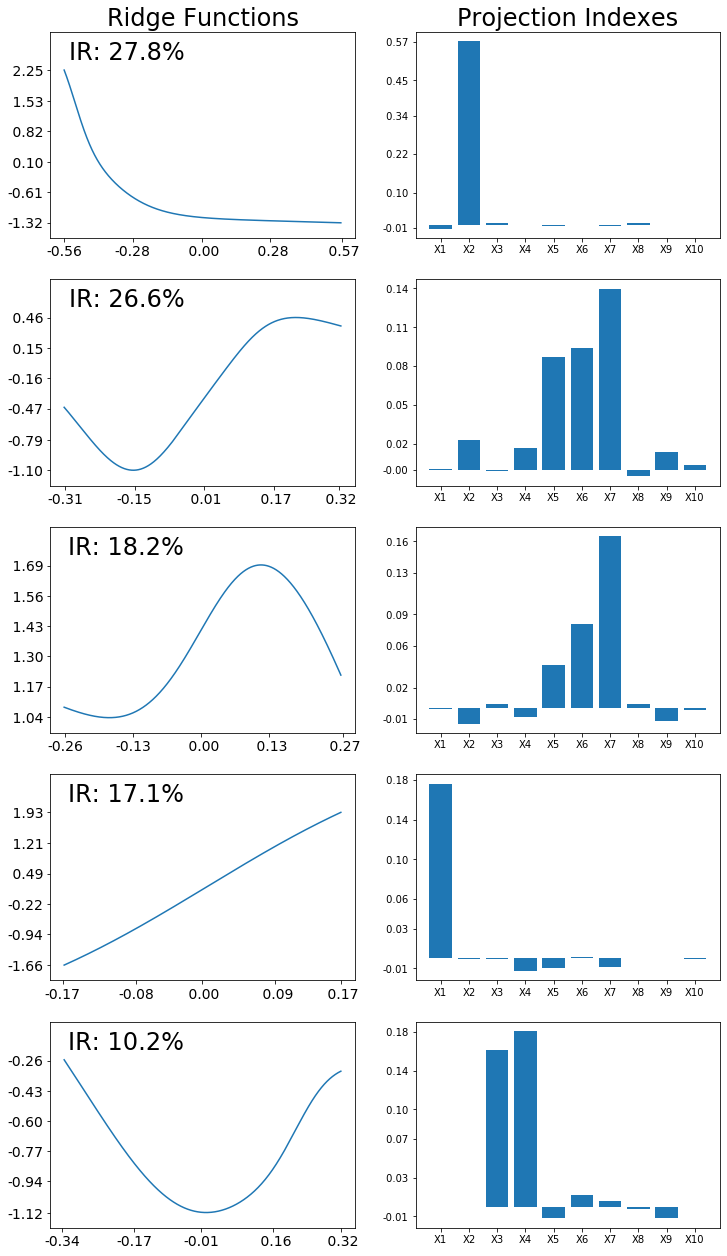

In [7]:
model = xNN(meta_info=meta_info,
               subnet_num=10,
               subnet_arch=[10, 6],
               task_type=task_type,
               activation_func=tf.tanh,
               batch_size=min(1000, int(train_x.shape[0] * 0.2)),
               training_epochs=10000,
               lr_bp=0.001,
               beta_threshold=0.05,
               tuning_epochs=100,
               l1_proj=best_l1_prob,
               l1_subnet=best_l1_subnet,
               verbose=True,
               val_ratio=0.2,
               early_stop_thres=500)
model.fit(train_x, train_y)
model.visualize("./", "xnn_demo")

In [8]:
tr_pred = model.predict(model.tr_x) 
val_pred = model.predict(model.val_x) 
pred_test = model.predict(test_x)

mse_stat = np.hstack([np.round(np.mean((meta_info["Y"]["scaler"].inverse_transform(tr_pred) - meta_info["Y"]["scaler"].inverse_transform(model.tr_y))**2),5),\
                             np.round(np.mean((meta_info["Y"]["scaler"].inverse_transform(val_pred) - meta_info["Y"]["scaler"].inverse_transform(model.val_y))**2),5),\
               np.round(np.mean((meta_info["Y"]["scaler"].inverse_transform(pred_test) - meta_info["Y"]["scaler"].inverse_transform(test_y))**2),5)])
print(mse_stat)

[0.99941 1.02802 0.99131]
